# Cardinality constrained portfolio optimization

### Import libraries

In [1]:
import cplex
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(148956)

### Generate random data for 10 stocks

In [3]:
# Random data for 10 stocks
n = 10
Q = np.random.random((n,n))
Q = np.dot(Q,Q.T)/1000
# Q
mu = np.random.rand(n) / 100
# mu

### Cardinality constrained mean-variance optimization problem

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w,z} & w^T Q w \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & \sum_{i=1}^n z_i = K \\
  & l \cdot z \leq w \leq u \cdot z \\
  & z = \{0,1\}
 \end{array}
\end{equation}

### Define and solve CPLEX model

In [4]:
cpx = cplex.Cplex()
cpx.objective.set_sense(cpx.objective.sense.minimize)

Optimization problem data (linear coefficient vector $c$, vector of lower bounds $lb$ and upper bounds $ub$)

In [5]:
c  = [0.0] * 2 * n
lb = [0.0] * 2 * n
ub = [1.0] * 2 * n

Define continuous and binary variables

In [6]:
variabtype = "C" * n + "B" * n
variabtype

'CCCCCCCCCCBBBBBBBBBB'

Define matrix $\tilde{A}$

In [7]:
Atilde = []
for k in range(n):
    Atilde.append([[0,2+k],[1.0,1.0]])
for k in range(n):
    Atilde.append([[1,2+k],[1.0,-1.0]])
Atilde

[[[0, 2], [1.0, 1.0]],
 [[0, 3], [1.0, 1.0]],
 [[0, 4], [1.0, 1.0]],
 [[0, 5], [1.0, 1.0]],
 [[0, 6], [1.0, 1.0]],
 [[0, 7], [1.0, 1.0]],
 [[0, 8], [1.0, 1.0]],
 [[0, 9], [1.0, 1.0]],
 [[0, 10], [1.0, 1.0]],
 [[0, 11], [1.0, 1.0]],
 [[1, 2], [1.0, -1.0]],
 [[1, 3], [1.0, -1.0]],
 [[1, 4], [1.0, -1.0]],
 [[1, 5], [1.0, -1.0]],
 [[1, 6], [1.0, -1.0]],
 [[1, 7], [1.0, -1.0]],
 [[1, 8], [1.0, -1.0]],
 [[1, 9], [1.0, -1.0]],
 [[1, 10], [1.0, -1.0]],
 [[1, 11], [1.0, -1.0]]]

Define vector $\tilde{u}$

In [8]:
my_sense    = "EE" + "L" * n
my_sense

'EELLLLLLLLLL'

In [9]:
u_tilde = [0.0] * (n+2)
u_tilde[0] = 1.0 # sum(w)=1.0
u_tilde[1] = 2.0 # cardinality K=2
u_tilde

[1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Define variable names

In [10]:
var_names = ["x_%s" % i for i in range(1,2*n+1)]
var_names

['x_1',
 'x_2',
 'x_3',
 'x_4',
 'x_5',
 'x_6',
 'x_7',
 'x_8',
 'x_9',
 'x_10',
 'x_11',
 'x_12',
 'x_13',
 'x_14',
 'x_15',
 'x_16',
 'x_17',
 'x_18',
 'x_19',
 'x_20']

Add linear constraints, bounds and linear part of objective function to CPLEX model

In [11]:
cpx.linear_constraints.add(rhs=u_tilde, senses=my_sense)

range(0, 12)

In [12]:
cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, types=variabtype, names=var_names)

range(0, 20)

Add quadratic part of objective function

In [13]:
Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]

In [14]:
for k in range(n):
    Qmat.append([[0],[0.0]])

In [15]:
cpx.objective.set_quadratic(Qmat)

Set concurrent solution algorithm

In [16]:
cpx.parameters.threads.set(4)
print("Setting number of threads = ", 4)

Setting number of threads =  4


Compute minimum variance portfolio with cardinality $K=2$

In [17]:
cpx.solve()

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 4
Found incumbent of value 0.002856 after 0.01 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 12 rows, 20 columns, and 40 nonzeros.
Reduced MIQP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 100 nonzeros.
Presolve time = 0.02 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 12 rows, 20 columns, and 40 nonzeros.
Reduced MIQP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 100 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.

In [18]:
print("Solution status = ", cpx.solution.get_status(), ":", end=' ')
print(cpx.solution.status[cpx.solution.get_status()])
print("Solution value  = ", cpx.solution.get_objective_value())

Solution status =  101 : MIP_optimal
Solution value  =  0.001770483074605611


In [19]:
for i in range(len(cpx.solution.get_values())):
    print("{0:5s}={1:7.3f}".format(var_names[i],cpx.solution.get_values()[i]))

x_1  =  0.000
x_2  =  0.000
x_3  =  0.561
x_4  =  0.000
x_5  =  0.000
x_6  =  0.000
x_7  =  0.000
x_8  =  0.000
x_9  =  0.439
x_10 =  0.000
x_11 =  0.000
x_12 =  0.000
x_13 =  1.000
x_14 = -0.000
x_15 =  0.000
x_16 =  0.000
x_17 =  0.000
x_18 =  0.000
x_19 =  1.000
x_20 = -0.000


In [20]:
w_minVar2 = cpx.solution.get_values()[:n]
var_minVar2 = np.dot(w_minVar2, np.dot(Q, w_minVar2))
ret_minVar2 = np.dot(mu, w_minVar2)
print("Minimum variance portfolio with cardinality K=2:\n")
print("Solution status =", cpx.solution.status[cpx.solution.get_status()])
print("Solution value =", cpx.solution.get_objective_value())
print("Variance       =", var_minVar2)
print("Return =", ret_minVar2)
print("Standard deviation =", np.sqrt(var_minVar2))

Minimum variance portfolio with cardinality K=2:

Solution status = MIP_optimal
Solution value = 0.001770483074605611
Variance       = 0.001770483074605611
Return = 0.007582478859683787
Standard deviation = 0.04207710867687573


Compute minimum variance portfolios with cardinality $K=1,2,...,10$

In [21]:
# Disable CPLEX output to screen
cpx.set_results_stream(None)
cpx.set_warning_stream(None)

In [22]:
w_cardC = []
var_cardC = []
p_cardC = []
for card in range(1,n+1):
    p_cardC.append(card)
    cpx.linear_constraints.set_rhs(1,card)
    cpx.solve()
    w_cur = cpx.solution.get_values()[:n]
    w_cardC.append(w_cur)
    var_cardC.append(np.dot(w_cur, np.dot(Q, w_cur)))

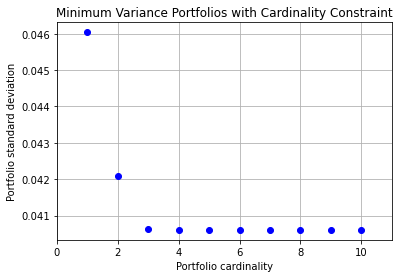

In [23]:
axC = plt.gca()
axC.plot(p_cardC, np.sqrt(var_cardC), 'bo')

axC.set_xlim([0,n+1])
axC.set_xlabel('Portfolio cardinality')
axC.set_ylabel('Portfolio standard deviation')
plt.title('Minimum Variance Portfolios with Cardinality Constraint')
axC.grid()
plt.show()

### Define and solve CPLEX model using CVXPY modeling environment

Compute minimum variance portfolio with cardinality $K=2$

In [24]:
w = cp.Variable(n)
z = cp.Variable(n, boolean=True)
K = cp.Parameter()
K.value = 2
prob = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                 [sum(w) == 1,
                  sum(z) == K,
                  w - z <= 0,
                  w >= 0])
prob.solve(solver=cp.CPLEX, verbose=True,cplex_params={"threads": 4})

print("\nSolution status: ", prob.status)
print("Solution optimal value: ", prob.value)
print("Solution w: ")
print(w.value)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 4
Found incumbent of value 0.002856 after 0.00 sec. (0.00 ticks)


Tried aggregator 1 time.
MIQP Presolve eliminated 10 rows and 0 columns.
Reduced MIQP has 12 rows, 20 columns, and 40 nonzeros.
Reduced MIQP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 100 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 12 rows, 20 columns, and 40 nonzeros.
Reduced MIQP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 100 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+ 

In [25]:
w_minVar = w.value
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
print("Minimum variance portfolio with cardinality K=2:\n")
print("Solution status =", prob.status)
print("Solution value =", prob.value)
print("Variance       =", var_minVar)
print("Standard deviation =", np.sqrt(var_minVar))

Minimum variance portfolio with cardinality K=2:

Solution status = optimal
Solution value = 0.001770483074605611
Variance       = 0.001770483074605611
Standard deviation = 0.04207710867687573


Compute minimum variance portfolios with cardinality $K=1,2,...,10$

In [26]:
w_cardP = []
var_cardP = []
p_cardP = []
for card in range(1,n+1):
    K.value = card
    p_cardP.append(card)
    prob.solve(solver=cp.CPLEX, verbose=False,cplex_params={"threads": 4})
    w_cardP.append(w.value)
    var_cardP.append(np.dot(w.value, np.dot(Q, w.value)))

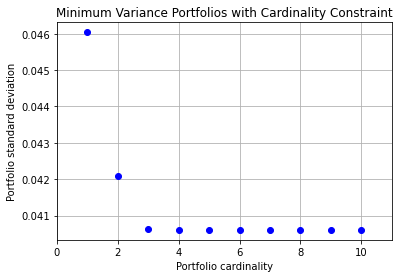

In [27]:
ax = plt.gca()
ax.plot(p_cardP, np.sqrt(var_cardP), 'bo')

ax.set_xlim([0,n+1])
ax.set_xlabel('Portfolio cardinality')
ax.set_ylabel('Portfolio standard deviation')
plt.title('Minimum Variance Portfolios with Cardinality Constraint')
ax.grid()
plt.show()

In [28]:
w_cardP

[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.       , 0.       , 0.5606138, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.4393862, 0.       ]),
 array([0.        , 0.        , 0.41043802, 0.        , 0.28343094,
        0.        , 0.        , 0.        , 0.30613104, 0.        ]),
 array([0.        , 0.        , 0.38202357, 0.05422462, 0.24845104,
        0.        , 0.        , 0.        , 0.31530077, 0.        ]),
 array([0.        , 0.        , 0.38202357, 0.05422462, 0.24845104,
        0.        , 0.        , 0.        , 0.31530077, 0.        ]),
 array([0.        , 0.        , 0.38202357, 0.05422462, 0.24845104,
        0.        , 0.        , 0.        , 0.31530077, 0.        ]),
 array([0.        , 0.        , 0.38202357, 0.05422462, 0.24845104,
        0.        , 0.        , 0.        , 0.31530077, 0.        ]),
 array([0.        , 0.        , 0.38202357, 0.05422462, 0.24845104,
        0.        , 0.        , 0.        , 0.31530077, 0.      